In [14]:
from transformers import BertTokenizer
import pandas as pd
import numpy as np
from tqdm.auto import tqdm  # 导入tqdm

# 加载BERT分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def batch_adjust_token_length(texts, lower_limit=50, upper_limit=512):
    # 将文本批量编码
    encoding = tokenizer(texts.tolist(), add_special_tokens=True, padding=True, truncation=False, return_tensors="pt", max_length=None)
    input_ids = encoding['input_ids']
    adjusted_texts = []
    
    for tokens in input_ids:
        length = len(tokens)
        if length < lower_limit:
            adjusted_texts.append(None)  # token数量低于下限，标记为删除
            continue
        
        # 如果token数量超过upper_limit，通过跳跃采样减少token数量
        while length > upper_limit:
            # 如果长度超过上限的两倍，则通过跳跃采样减少token数量
            if length > 2 * upper_limit:
                # 通过跳跃采样减少token数量，确保最终长度接近但不超过upper_limit
                step = length // upper_limit
                tokens = tokens[::step]
            else:
                # 如果长度没有超过上限的两倍，但仍然超过上限，则每隔一个token取一个
                tokens = tokens[::2]
            length = len(tokens)
        adjusted_text = tokenizer.decode(tokens, skip_special_tokens=True)
        adjusted_texts.append(adjusted_text)
    
    return adjusted_texts

# 读取CSV文件
df = pd.read_csv('./dataset/Eclipse_total_havedeletedwordandlowdeveloper.csv', encoding='latin-1')

# 确保description列中的所有数据都是字符串类型
df['description'] = df['description'].astype(str)

# 应用批量调整token长度的函数 不过感觉影响不大 影响因素应该是磁盘读写速度
# 注意：根据你的数据集大小，你可能需要将数据分批处理
batch_size = 1  # 或者根据你的内存大小调整
results = []

# 使用tqdm显示进度条
for start in tqdm(range(0, df.shape[0], batch_size), desc="Processing"):
    end = start + batch_size
    batch_texts = df['description'][start:end]
    batch_results = batch_adjust_token_length(batch_texts)
    results.extend(batch_results)

df['description'] = results

# 删除description为None的行
df.dropna(subset=['description'], inplace=True)

# 保存处理后的数据集到新的CSV文件
df.to_csv('./dataset/Eclipse_total_processed_jump.csv', index=False, encoding='latin-1')

Processing:   0%|          | 0/40657 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


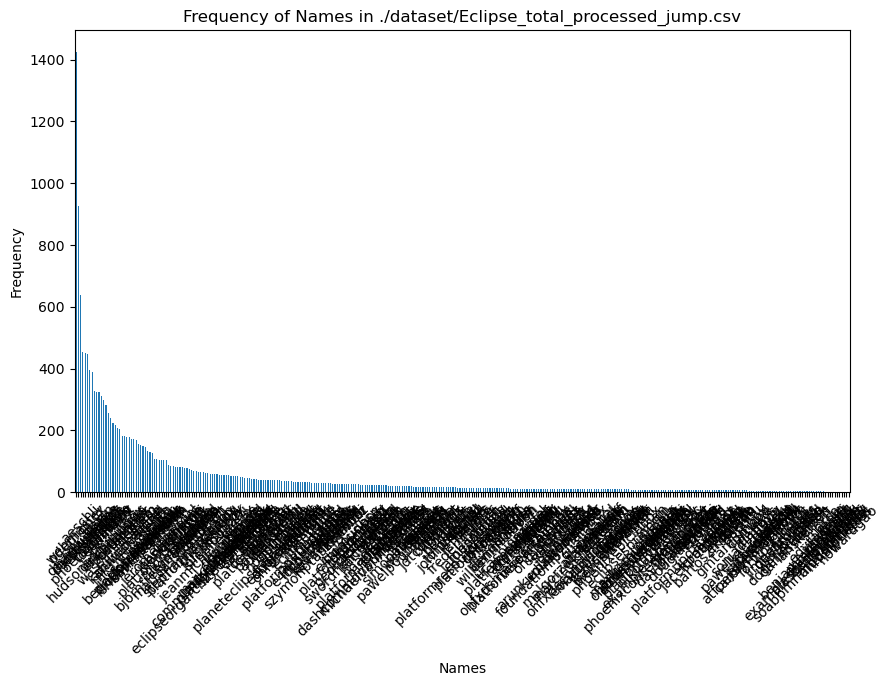

In [15]:
#人名标签分布
from transformers import BertTokenizer
import pandas as pd
import matplotlib.pyplot as plt

def plot_who_frequency(file_path, sep=','):
    df = pd.read_csv(file_path, encoding='latin-1', sep=sep)
    # 统计`who`列中每个人名出现的次数
    who_frequency = df['developer'].value_counts()
    
    # 绘制人名出现频率的图表
    plt.figure(figsize=(10, 6))
    who_frequency.plot(kind='bar')
    plt.title(f'Frequency of Names in {file_path}')
    plt.xlabel('Names')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # 旋转x轴标签，以便更清楚地显示
    plt.show()

# 指定文件路径
files = ['./dataset/Eclipse_total_processed_jump.csv']

# 对每个文件进行统计和绘图
for file in files:
    if 'bug_raw.csv' in file:
        sep = '@@,,@@'  # 对于第一个文件使用特定分隔符
    else:
        sep = ','  # 对于其他文件使用默认分隔符
    plot_who_frequency(file, sep)

In [17]:
import pandas as pd

def remove_low_frequency_developers_and_count(file_path, sep=','):
    df = pd.read_csv(file_path, encoding='latin-1', sep=sep)
    original_row_count = df.shape[0]  # 原始行数

    # 统计每个developer出现的次数
    developer_counts = df['developer'].value_counts()

    # 筛选出出现次数大于或等于10的developer
    developers_morethan10 = developer_counts[developer_counts >= 10].index

    # 删除出现次数小于10的行
    filtered_df = df[df['developer'].isin(developers_morethan10)]
    filtered_row_count = filtered_df.shape[0]  # 筛选后的行数

    # 计算删除的行数和删除的人名种类数
    deleted_row_count = original_row_count - filtered_row_count
    deleted_developer_count = len(developer_counts) - len(developers_morethan10)

    # 保存处理后的数据集到新的CSV文件
    filtered_df.to_csv(file_path.replace('.csv', '_final_deleted_lowdeveloper_again.csv'), index=False, encoding='latin-1')

    return deleted_row_count, deleted_developer_count

# 指定文件路径
file_path = './dataset/Eclipse_total_processed_jump.csv'
deleted_row_count, deleted_developer_count = remove_low_frequency_developers_and_count(file_path)

print(f"删除的行数: {deleted_row_count}")
print(f"删除的人名种类数: {deleted_developer_count}")

删除的行数: 688
删除的人名种类数: 106


Number of rows in ./dataset/Eclipse_total_havedeletedwordandlowdeveloper.csv: 40657


Tokenizing: 100%|██████████| 40657/40657 [02:04<00:00, 325.44it/s]


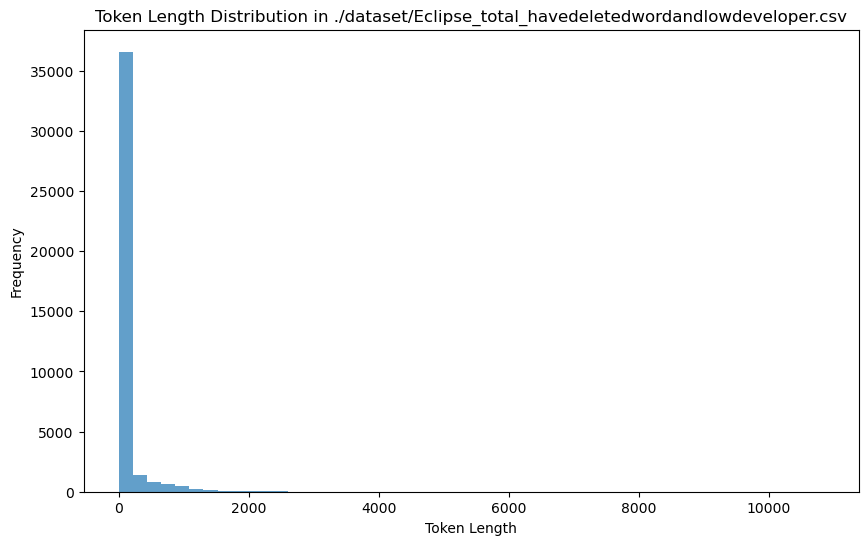

BERT Token Statistics for ./dataset/Eclipse_total_havedeletedwordandlowdeveloper.csv:
Number of Rows: 40657
Average Token Length: 126.93895270187176
Minimum Token Length: 3
Maximum Token Length: 10837
Median Token Length: 42.0

Number of rows in ./dataset/Eclipse_total_processed_jump.csv: 17327


Tokenizing: 100%|██████████| 17327/17327 [01:01<00:00, 281.82it/s]


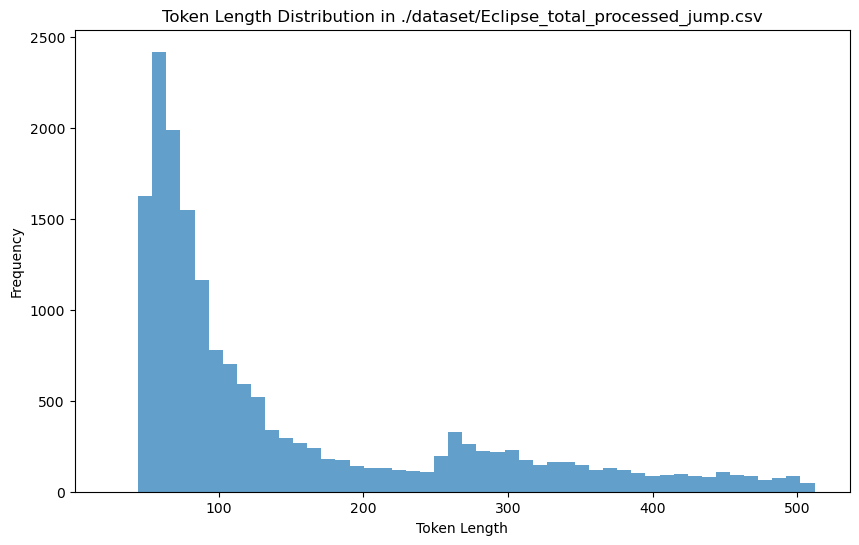

BERT Token Statistics for ./dataset/Eclipse_total_processed_jump.csv:
Number of Rows: 17327
Average Token Length: 148.32533040918798
Minimum Token Length: 25
Maximum Token Length: 512
Median Token Length: 93.0



In [16]:
# 进度条版本
from transformers import BertTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 加载BERT分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def calculate_bert_token_statistics_and_plot(file_path, sep=','):
    df = pd.read_csv(file_path, encoding='latin-1', sep=sep)
    # 统计行数
    num_rows = df.shape[0]
    print(f"Number of rows in {file_path}: {num_rows}")
    
    # 确保description列中的所有数据都是字符串类型
    df['description'] = df['description'].astype(str).fillna('')
    
    # 使用BERT分词器对description列进行分词，并计算每个文本的token数量
    # 使用tqdm显示进度条
    token_lengths = []
    for desc in tqdm(df['description'], desc="Tokenizing"):
        tokens = tokenizer.encode(desc, add_special_tokens=True)
        token_lengths.append(len(tokens))
    
    # 计算平均长度、最小长度、最大长度和中位数
    token_lengths = pd.Series(token_lengths)  # 转换为pandas序列以利用统计函数
    avg_length = token_lengths.mean()
    min_length = token_lengths.min()
    max_length = token_lengths.max()
    median_length = token_lengths.median()
    
    # 绘制token数分布图
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=50, alpha=0.7)
    plt.title(f'Token Length Distribution in {file_path}')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.show()
    
    return avg_length, min_length, max_length, median_length, num_rows
# 指定文件路径
files = ['./dataset/Eclipse_total_havedeletedwordandlowdeveloper.csv', './dataset/Eclipse_total_processed_jump.csv']

# 对每个文件进行统计和绘图
for file in files:
    if 'bug_raw.csv' in file:
        sep = '@@,,@@'  # 对于第一个文件使用特定分隔符
    else:
        sep = ','  # 对于其他文件使用默认分隔符
    avg_length, min_length, max_length, median_length, num_rows = calculate_bert_token_statistics_and_plot(file, sep)
    print(f"BERT Token Statistics for {file}:")
    print(f"Number of Rows: {num_rows}")
    print(f"Average Token Length: {avg_length}")
    print(f"Minimum Token Length: {min_length}")
    print(f"Maximum Token Length: {max_length}")
    print(f"Median Token Length: {median_length}\n")

In [10]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# 加载数据集
df = pd.read_csv('./dataset/Eclipse_total.csv', encoding='latin-1')

# 初始化统计字典
stop_delete = {}  # 统计被删除的停用词
frequent_delete = {}  # 统计被删除的高频和低频词
stop_words = set(stopwords.words('english'))  # 加载英文停用词

# 清理字符串的函数
def clean_str(string):
    if not isinstance(string, str):
        return ""  # 如果输入不是字符串，返回空字符串
    string = re.sub(r'[^A-Za-z0-9\s]', '', string)
    string = string.lower()
    return string

# 统计词频的字典
word_freq = {}

# 对每一列进行处理
for column in df.columns:
    for index, row in df.iterrows():
        text = clean_str(row[column])
        words = word_tokenize(text)
        for word in words:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1

# 清理文档的函数
def clean_doc(doc):
    cleaned_doc = []
    words = doc.split()
    for word in words:
        if word in stop_words:
            stop_delete[word] = stop_delete.get(word, 0) + 1
            continue
        if word_freq.get(word, 0) < 5:
            frequent_delete[word] = frequent_delete.get(word, 0) + 1
            continue
        cleaned_doc.append(word)
    return ' '.join(cleaned_doc)

# 直接更新每一列
for column in df.columns:
    df[column] = df[column].apply(lambda x: clean_doc(clean_str(x)))

# 统计每个开发者出现的次数
developer_counts = df['developer'].value_counts()

# 筛选出出现次数大于10的开发者
developers_morethan10 = developer_counts[developer_counts > 10].index

# 筛选出这些开发者对应的行
filtered_rows = df[df['developer'].isin(developers_morethan10)]

# 找出被删除的开发者及其出现次数
deleted_developers = developer_counts[~developer_counts.index.isin(developers_morethan10)]

# 打印被删除的开发者及其出现次数
print("被删除的开发者及其出现次数:")
print(deleted_developers)

# 统计被删除的开发者数量
print("\n被删除的开发者数量:", len(deleted_developers))

# 统计删除的行数
original_rows = df.shape[0]
filtered_rows_count = filtered_rows.shape[0]
deleted_rows_count = original_rows - filtered_rows_count
print("删除的行数:", deleted_rows_count)

# 保存处理后的数据集到新的CSV文件
filtered_rows.to_csv('./dataset/Eclipse_total_havedeletedwordandlowdeveloper.csv', index=False, encoding='latin-1')

# 显示删除的停用词和高低频词统计
print("Deleted stopwords:", stop_delete)
print("Deleted frequent/infrequent words:", frequent_delete)

[nltk_data] Error loading punkt: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


被删除的开发者及其出现次数:
developer
djohnson           10
debbiewilson       10
unknown2           10
samratdhillon      10
socgeneralinbox    10
                   ..
pinnamur            1
allangodding        1
jansievers          1
wajnberg            1
fchouinard          1
Name: count, Length: 349, dtype: int64

被删除的开发者数量: 349
删除的行数: 1173
Deleted stopwords: {'i': 8310, 'd': 3562, 'o': 1104, 'in': 5823, 've': 4337, 't': 1806, 'ma': 89, 'y': 229, 'a': 3538, 'and': 1632, 'about': 925, 're': 1444, 's': 8460, 'on': 295, 'same': 28, 'do': 235, 'of': 140, 'to': 417, 'not': 164, 'if': 308, 'so': 316, 'for': 222, 'up': 489, 'm': 8137, 'off': 188, 'by': 84, 'how': 51, 'out': 949, 'more': 18, 'no': 295, 'down': 228, 'or': 288, 'am': 293, 'me': 308, 'own': 132, 'this': 496, 'before': 131, 'all': 264, 'll': 1347, 'as': 120, 'you': 42, 'at': 105, 'should': 39, 'any': 17, 'doesn': 24, 'does': 16, 'some': 68, 'other': 91, 'are': 17, 'over': 22, 'its': 18, 'can': 44, 'most': 20, 'too': 6, 'don': 101, 'with': 